# How do we assess image quality?

**Author Contact:** <br>
Email: [jamesmcclure@lbpm-sim.org](mailto:jamesmcclure@lbpm-sim.org)

Two key factors will always be required to generate good simulations
* pore space is connected
* image resolution is sufficient to capture rock microstructure

Morphological analysis provides a quick and easy (cheap!) way to verify that images are worth additional effort

(it is also a great way to initialize oil-water configurations)

In [85]:
# read csv file and plot data
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

# Image processsing
import skimage

# Image visualization
import tifffile

# Other utility functions
import os
# TODO: be smarter about changing directory
os.chdir('/home/mcclurej/Programs/porescale_quantification_workshop/tutorial')
import glob
import src.utils
# if glob.glob('data/*.tif') == []:
#     src.utils.get_datafiles()
from ipywidgets import interact, interactive
import ipywidgets as widgets
from IPython.display import display, clear_output

# Running morphological drainage with LBPM

LBPM includes a pre-processing tool to generate morphological drainage curves (we use it as part of computational SCAL worflows)

Inputs are:
* a digital rock image
* a target water saturation value (i.e. how much oil to inject using a drainage process)

Outputs are:
* a digital rock image
* a space-delimited CSV file `morphdrain.csv` that lists the water saturation `sw` and radius `r`

The simulator is launched from the command line like other LBPM simulators:
```
mpirun -np 1 $LBPM_BIN/lbpm_morphdrain_pp input.db
```

(for more examples see http://lbpm-sim.org/examples/morphology/morphOpen.html )


['../data/beadpack.tif', '../data/castlegate.tif', '../data/sandpack.tif', '../data/mtgambier.tif']


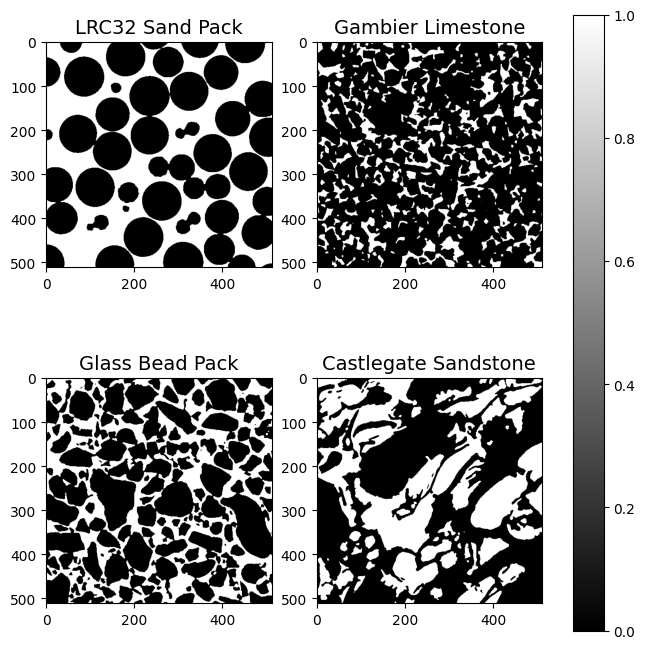

In [86]:
img_list = glob.glob('../data/*.tif')
print(img_list)
segmented_lrc32, segmented_Gambier, segmented_bead_pack_512, segmented_castle_512 = [tifffile.imread(tif_img) for tif_img in img_list]

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(8,8))
ax = ax.flatten()

ax[0].imshow(segmented_lrc32[0,:,:], cmap='gray')
ax[0].set_title('LRC32 Sand Pack',fontsize=14)

ax[1].imshow(segmented_Gambier[0,:,:], cmap='gray')
ax[1].set_title('Gambier Limestone',fontsize=14)

ax[2].imshow(segmented_bead_pack_512[0,:,:], cmap='gray')
ax[2].set_title('Glass Bead Pack',fontsize=14)

im = ax[3].imshow(segmented_castle_512[0,:,:], cmap='gray')
ax[3].set_title('Castlegate Sandstone',fontsize=14)

fig.colorbar(im, ax=ax.tolist())

plt.show()

# Let's look at the bead pack first

(This image is fairly homogeneous and well-resolved)

Essential portion of the LBPM input file `input.db` is below:
```
Domain {
   Filename = "segmented_bead_pack_512.ubc"
   voxel_length = 17.4
   N = 512, 512, 512
   n = 256, 256, 256
   nproc = 1, 1, 1
   ReadType ="8bit"
   // key values set by image labeling 
   ReadValues = 0, 1
   WriteValues = 1, 0 
   // keys below set by color model
   BC = 0
   InletLayers = 0, 0, 5 
   OutletLayers = 0, 0, 5 
   Sw = 0.1
}
```
This will do the following things:
* Map `ReadValues = 0, 1` (from original image) to `WriteValues=1, 0`
* Output image size will match the simulation size
* Target saturation `Sw = 0.30`


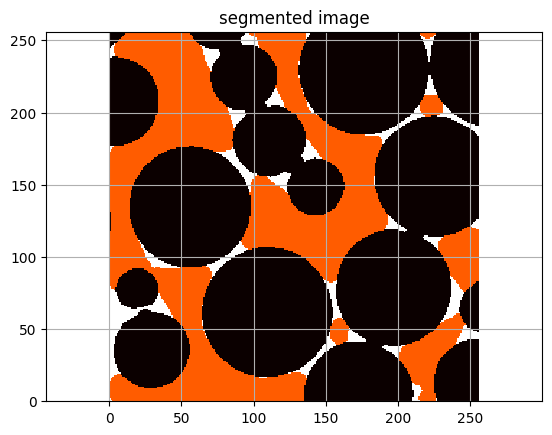

In [101]:
def PlotMorphImage(input_file) :
    ID=tifffile.imread(input_file)
    plt.figure(2)
    plt.title('segmented image')
    plt.pcolormesh(ID[100,:,:],cmap='hot')
    plt.xlabel('')
    plt.ylabel('')
    plt.grid(True)
    plt.axis('equal')
    plt.show()
    

PlotMorphImage("../data/morphdrain/segmented_bead_pack_256_morphdrain.tif")

# Mercury injection curve

Radius of morphological opening is decreased to decrease the water saturation. 

This provides a fair approximation of oil drainage under water wet conditions 
(may miss irredicuble water saturation)

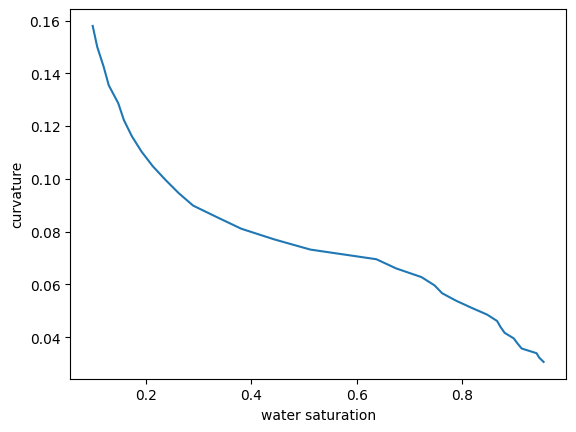

In [88]:
M=pd.read_csv("../lbpm/beadpack/morphdrain.csv",sep=" ")

pc=1/M['radius']
plt.figure()
plt.plot(M['sw'],pc)
plt.xlabel('water saturation')
plt.ylabel('curvature')
plt.show()

# Morphological Drainage as Image Quality Control

* The morphological opening tells us how large the flow channels are likely to be
* Under-resolved flow channels will lead to "bad" simulation results
* It will be clear if the porespace is not well-connected
* Rule of thumb: 10 voxels across a pore-throat will ensure scale separation between water films and flow channels

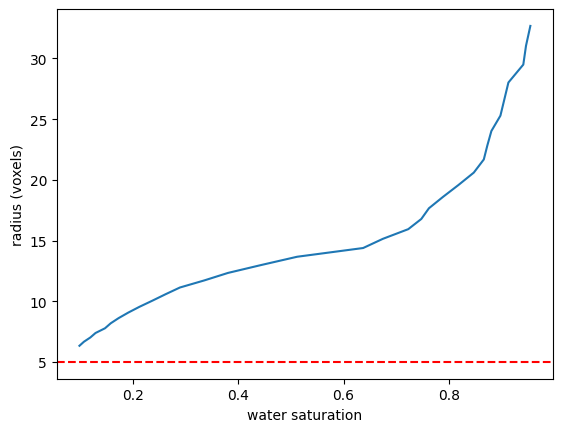

In [89]:
plt.figure()
plt.plot(M['sw'],M['radius'])
plt.axhline(y=5,color='r',linestyle='dashed')
plt.xlabel('water saturation')
plt.ylabel('radius (voxels)')
plt.show()

# Now consider the Castlegate sandstone

Relevant content of `input.db`
```
Domain {
   Filename = "segmented_castle_512.ubc"
   voxel_length = 5.6
   N = 512, 512, 512
   n = 256, 256, 256
   nproc = 1, 1, 1
   ReadType ="8bit"
   // key values set by image labeling 
   ReadValues = 0, 1, 2 
   WriteValues = 1, 0, 2 
   // keys below set by color model
   BC = 0
   InletLayers = 0, 0, 5 
   OutletLayers = 0, 0, 5 
   Sw = 0.05
}
```



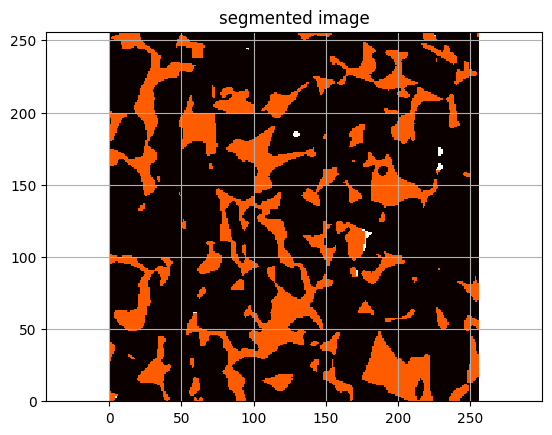

In [90]:
PlotMorphImage("../data/morphdrain/segmented_castle_256_morphdrain5.tif")

## (note how obvious the irreducible water saturation is for this image)

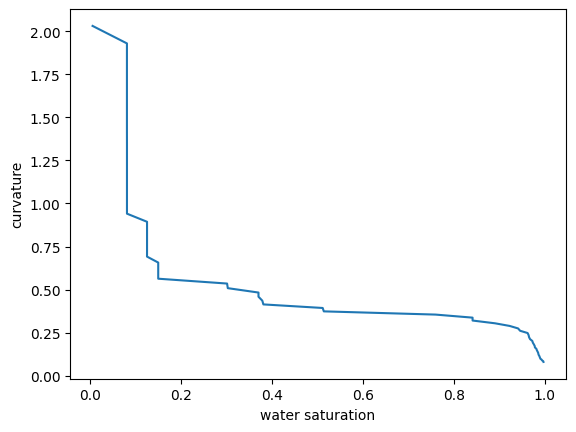

In [91]:
M=pd.read_csv("../lbpm/castle/morphdrain.csv",sep=" ")

pc=1/M['radius']
plt.figure()
plt.plot(M['sw'],pc)
plt.xlabel('water saturation')
plt.ylabel('curvature')
plt.show()

# Quality control check

### Morphological radius clearly shows that the flow pathways will break my rule of thumb!

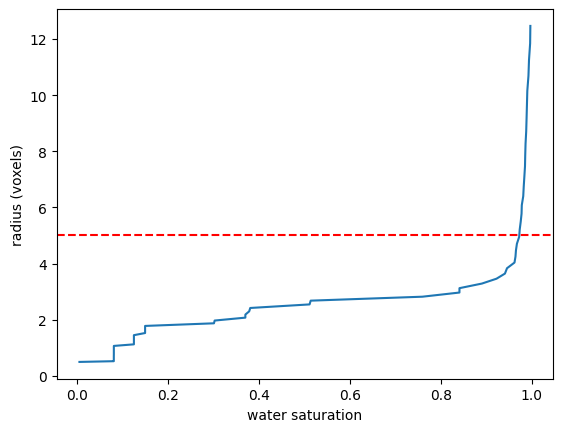

In [92]:
plt.figure()
plt.plot(M['sw'],M['radius'])
plt.axhline(y=5,color='r',linestyle='dashed')
plt.xlabel('water saturation')
plt.ylabel('radius (voxels)')
plt.show()

# Gambier 

```
Domain {
   Filename = "segmented_Gambier_512.ubc"
   voxel_length = 3.0
   N = 512, 512, 512
   n = 256, 256, 256
   nproc = 1, 1, 1
   ReadType ="8bit"
   // key values set by image labeling 
   ReadValues = 0, 1, 2 
   WriteValues = 1, 0, 2 
   // keys below set by color model
   BC = 0
   InletLayers = 0, 0, 5 
   OutletLayers = 0, 0, 5 
   Sw = 0.1
}
```

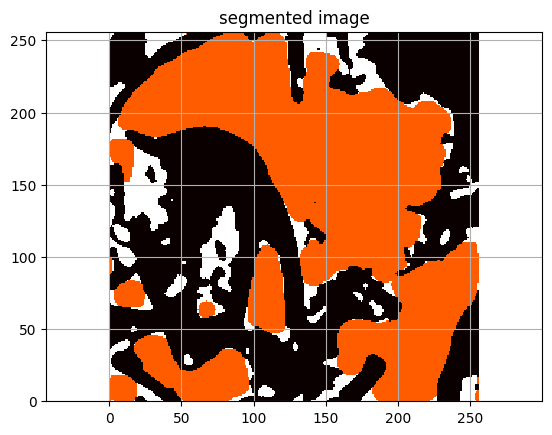

In [93]:
PlotMorphImage("../data/morphdrain/segmented_Gambier_256_morphdrain30.tif")

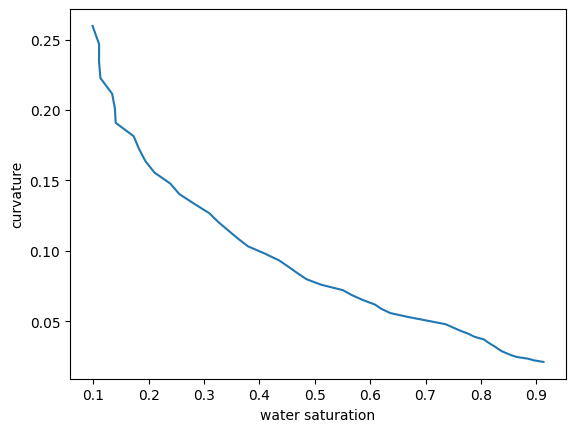

In [94]:
M=pd.read_csv("../lbpm/gambier/morphdrain.csv",sep=" ")

pc=1/M['radius']
plt.figure()
plt.plot(M['sw'],pc)
plt.xlabel('water saturation')
plt.ylabel('curvature')
plt.show()

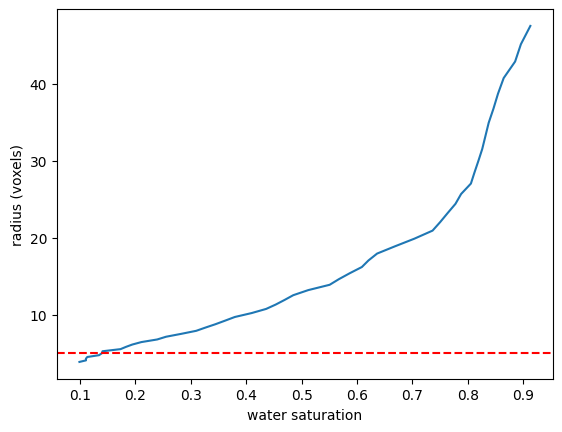

In [96]:
plt.figure()
plt.plot(M['sw'],M['radius'])
plt.axhline(y=5,color='r',linestyle='dashed')
plt.xlabel('water saturation')
plt.ylabel('radius (voxels)')
plt.show()